# **Project Description**

This project presents a study on applying Deep Reinforcement Learning (DRL) algorithms to the task of continuous portfolio optimization.

The goal is to train intelligent agents to dynamically allocate capital across a diverse basket of assets, aiming to maximize risk-adjusted returns.

**Key Features and Methodology**:


**Custom DRL Environment**:

The core of the project is a custom-built, modern gymnasium-compatible environment, StockTradingEnv.

This environment transforms the complex financial problem into a standard sequential decision-making process suitable for DRL.

**Constraints**:

It incorporates crucial real-world constraints, including transaction costs and maximum trade limits, ensuring the learned policies are practical.

**Comprehensive State Space**:

The agent's observation space is enriched with a lookback window of price history and popular technical indicators (e.g., MACD, RSI, SMA) to provide the necessary market context for informed trading decisions.

**Algorithm Tournament**:

Five distinct DRL agents were trained and benchmarked against the same market data to identify the optimal strategy:

**Policy Gradient Methods**:

An implementation of the REINFORCE algorithm.

**Modern Actor-Critic Methods** (Stable-Baselines3):

Soft Actor-Critic (SAC), Proximal Policy Optimization (PPO), Deep Deterministic Policy Gradient (DDPG), and Advantage Actor-Critic (A2C).

**Tournament's rules**:

The algorithms competed in a Sharpe Ratio Tournament, with performance evaluated rigorously on an unseen test dataset.

The primary performance metric was the **Sharpe Ratio**, which measures the agent's excess return relative to its volatility (risk).

The results successfully identified the highest-performing agent, demonstrating the significant potential of DRL to generate high risk-adjusted returns and outperform passive strategies.

**WARNING**:

This notebook is not a financial advisor.



In [1]:
pip install Shimmy

In [2]:
pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 3.5 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from stable_baselines3 import DQN, A2C, PPO, DDPG, SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.callbacks import BaseCallback
import gymnasium as gym
from gymnasium import spaces

[                       0%                       ]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[******                13%                       ]  2 of 15 completed/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[*************         27%                       ]  4 of 15 completed/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future 

--- 1. Fetching and Preprocessing Data ---


[*******************   40%                       ]  6 of 15 completed/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[**********************47%                       ]  7 of 15 completed/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent d


--- 4. Defining and Training DRL Agents (Tournament) ---

--- Training DDPG ---

--- Training SAC ---

--- Training A2C ---

--- Training PPO ---

--- Training REINFORCE ---
Episode 10, Final Value: $100,000.00
Episode 20, Final Value: $100,000.00
Episode 30, Final Value: $100,000.00
Episode 40, Final Value: $100,000.00
Episode 50, Final Value: $100,000.00
Episode 60, Final Value: $100,000.00
Episode 70, Final Value: $100,000.00
Episode 80, Final Value: $100,000.00
Episode 90, Final Value: $100,000.00
Episode 100, Final Value: $100,000.00

--- Evaluating DDPG ---

--- Evaluating SAC ---

--- Evaluating A2C ---

--- Evaluating PPO ---

--- Evaluating REINFORCE ---

--- 6. Portfolio Metrics and Tournament Results ---

### Performance Metrics (Test Set) ###
           Final Value Cumulative Return (%) Annualized Volatility  \
REINFORCE  $161,034.46                61.03%                0.1773   
SAC        $159,544.44                59.54%                0.2015   
A2C        $149,167.92  

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


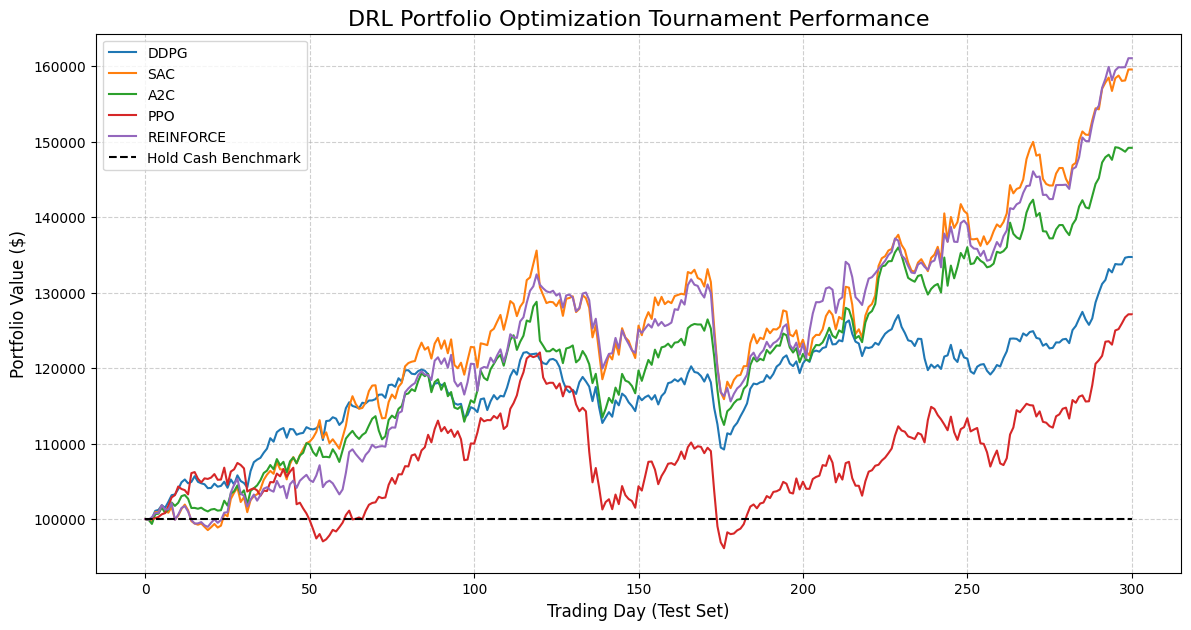


--------------------------------------------------
### TOURNAMENT WINNER: REINFORCE ###
The winner is chosen based on the highest Sharpe Ratio, representing the best risk-adjusted return.
Final Portfolio Value: $161,034.46
Sharpe Ratio: 2.7759


In [7]:



SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

TICKERS = [
    "AZM.MI", "BAMI.MI", "BGN.MI", "BMED.MI", "BPE.MI",
    "ALV.DE", "CBK.DE", "DBK.DE", "DB1.DE", "DTE.DE",
    "BNP.PA", "CS.PA", "GLE.PA", "ACA.PA", "CAP.PA"
]

START_DATE = "2019-01-01"
END_DATE = "2025-01-31"
INITIAL_BALANCE = 100000


print("--- 1. Fetching and Preprocessing Data ---")
data = yf.download(TICKERS, start=START_DATE, end=END_DATE, interval="1d", auto_adjust=False)

if data.empty:
    raise ValueError("Failed to download financial data.")

close_prices = data['Close'].ffill().bfill()



def add_technical_indicators(df):

    df_out = df.copy()
    for ticker in TICKERS:
        if ticker in df_out.columns:

            exp12 = df_out[ticker].ewm(span=12, adjust=False).mean()
            exp26 = df_out[ticker].ewm(span=26, adjust=False).mean()
            df_out[f'MACD_{ticker}'] = exp12 - exp26


            delta = df_out[ticker].diff()
            gain = (delta.where(delta > 0, 0)).ewm(span=14, adjust=False).mean()
            loss = (-delta.where(delta < 0, 0)).ewm(span=14, adjust=False).mean()
            with np.errstate(divide='ignore', invalid='ignore'):
                 RS = gain / loss
                 df_out[f'RSI_{ticker}'] = 100 - (100 / (1 + RS))
            df_out[f'RSI_{ticker}'] = df_out[f'RSI_{ticker}'].fillna(50)


            df_out[f'SMA10_{ticker}'] = df_out[ticker].rolling(window=10).mean()

    return df_out.dropna()

features_df = add_technical_indicators(close_prices)
price_data = features_df[TICKERS]
feature_columns = [col for col in features_df.columns if col not in TICKERS]
feature_data = features_df[feature_columns]



class StockTradingEnv(gym.Env):

    metadata = {'render.modes': ['human']}

    def __init__(self, df_price, df_features, initial_balance=INITIAL_BALANCE, lookback_window=10):
        super().__init__()
        self.price_data = df_price.values
        self.feature_data = df_features.values
        self.n_stocks = len(TICKERS)
        self.initial_balance = initial_balance
        self.lookback_window = lookback_window
        self.max_trade_pct = 0.25
        self.transaction_cost = 0.001

        self.action_space = spaces.Box(low=-1, high=1, shape=(self.n_stocks,), dtype=np.float32)

        self.state_dim = (self.lookback_window * self.n_stocks) + self.feature_data.shape[1] + 2
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(self.state_dim,), dtype=np.float32
        )

        self.reset(seed=SEED)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.current_step = self.lookback_window
        self.balance = self.initial_balance
        self.stock_holdings = np.zeros(self.n_stocks, dtype=np.float32)
        self.portfolio_value = self.initial_balance
        self.portfolio_history = [self.portfolio_value]
        self.cash_in_hand = self.initial_balance

        observation = self._get_observation()
        info = {}

        return observation, info

    def _get_observation(self):

        step_idx = min(self.current_step, len(self.price_data) - 1)

        current_prices = self.price_data[step_idx, :]
        current_features = self.feature_data[step_idx, :]


        start_idx = max(0, step_idx - self.lookback_window)
        lookback_prices_slice = self.price_data[start_idx:step_idx, :]


        if lookback_prices_slice.shape[0] < self.lookback_window:
            padding = np.zeros((self.lookback_window - lookback_prices_slice.shape[0], self.n_stocks))
            lookback_prices = np.concatenate([padding, lookback_prices_slice], axis=0).flatten()
        else:
            lookback_prices = lookback_prices_slice.flatten()

        current_stock_value = np.sum(self.stock_holdings * current_prices)
        current_portfolio_value = self.cash_in_hand + current_stock_value

        state = np.concatenate([
            lookback_prices,
            current_features,
            [current_portfolio_value],
            [self.cash_in_hand]
        ])
        return state.astype(np.float32)

    def step(self, action):


        if not self.action_space.contains(action):
            print(f"Warning: Action {action} is outside the action space. Clipping.")
            action = np.clip(action, self.action_space.low, self.action_space.high)

        assert self.action_space.contains(action)

        prev_portfolio_value = self.portfolio_history[-1]
        self.current_step += 1

        terminated = False
        truncated = False


        if self.current_step >= len(self.price_data) - 1:
            terminated = True
            reward = 0


            observation = self._get_observation()
            info = {'portfolio_value': self.portfolio_value}

            return observation, reward, terminated, truncated, info


        else:

            new_prices = self.price_data[self.current_step, :]
            current_stock_value = np.sum(self.stock_holdings * new_prices)
            self.portfolio_value = self.cash_in_hand + current_stock_value


            desired_change_value = action * self.portfolio_value * self.max_trade_pct


            total_cost_of_transactions = 0.0

            for i in range(self.n_stocks):
                change = desired_change_value[i]
                price_i = new_prices[i]

                if price_i <= 0:
                    continue

                if change > 0:
                    buy_amount_needed = change
                    cost = buy_amount_needed * (1 + self.transaction_cost)

                    if self.cash_in_hand >= cost:
                        buy_shares = buy_amount_needed / price_i
                        self.stock_holdings[i] += buy_shares
                        self.cash_in_hand -= cost
                        total_cost_of_transactions += buy_amount_needed * self.transaction_cost
                    else:
                        affordable_buy_amount = self.cash_in_hand / (1 + self.transaction_cost)
                        affordable_shares = affordable_buy_amount / price_i
                        self.stock_holdings[i] += affordable_shares
                        self.cash_in_hand = 0
                        total_cost_of_transactions += affordable_buy_amount * self.transaction_cost

                elif change < 0:
                    sell_amount_needed = -change
                    sell_shares = sell_amount_needed / price_i

                    if self.stock_holdings[i] >= sell_shares:
                        self.stock_holdings[i] -= sell_shares
                        revenue = sell_amount_needed * (1 - self.transaction_cost)
                        self.cash_in_hand += revenue
                        total_cost_of_transactions += sell_amount_needed * self.transaction_cost
                    else:
                        sell_shares = self.stock_holdings[i]
                        sell_amount_value = sell_shares * price_i
                        revenue = sell_amount_value * (1 - self.transaction_cost)
                        self.stock_holdings[i] = 0
                        self.cash_in_hand += revenue
                        total_cost_of_transactions += sell_amount_value * self.transaction_cost


            current_stock_value = np.sum(self.stock_holdings * new_prices)
            self.portfolio_value = self.cash_in_hand + current_stock_value

            reward = (self.portfolio_value - prev_portfolio_value) / prev_portfolio_value
            reward = np.clip(reward, -0.1, 0.1)
            self.portfolio_history.append(self.portfolio_value)

        observation = self._get_observation()
        info = {'portfolio_value': self.portfolio_value}


        if self.portfolio_value < self.initial_balance * 0.5:
             terminated = True

        return observation, reward, terminated, truncated, info

    def render(self, mode='human'):
        screen_width = 80
        portfolio_str = f"Step: {self.current_step}/{len(self.price_data)-1}"
        value_str = f"| Value: ${self.portfolio_value:,.2f}"
        cash_str = f"| Cash: ${self.cash_in_hand:,.2f}"
        print(f"{portfolio_str:<15}{value_str:<25}{cash_str}")


train_split = int(0.8 * len(features_df))
train_prices = price_data.iloc[:train_split]
train_features = feature_data.iloc[:train_split]
test_prices = price_data.iloc[train_split:]
test_features = feature_data.iloc[train_split:]


train_env = DummyVecEnv([lambda: StockTradingEnv(train_prices, train_features)])
test_env = DummyVecEnv([lambda: StockTradingEnv(test_prices, test_features)])



class PortfolioCallback(BaseCallback):

    def __init__(self, verbose=0):
        super(PortfolioCallback, self).__init__(verbose)
        self.history = [INITIAL_BALANCE]

    def _on_step(self) -> bool:

        if self.locals['dones'][0]:
            info = self.locals['infos'][0]

            final_value = info.get('portfolio_value')
            if final_value is not None:
                self.history.append(final_value)
                self.logger.record('train/portfolio_value', final_value)
        return True




N_STEPS = 50000
print("\n--- 4. Defining and Training DRL Agents (Tournament) ---")


class PolicyNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.fc(x)

class REINFORCE_Agent:
    def __init__(self, state_dim, action_dim):
        self.policy = PolicyNet(state_dim, action_dim)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=1e-3)
        self.gamma = 0.99
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.policy.to(self.device)
        self.action_dim = action_dim

    def select_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        action_mean = self.policy(state)
        action_std = torch.tensor([0.1] * self.action_dim).to(self.device)
        m = torch.distributions.Normal(action_mean, action_std)
        action = m.sample()
        action = torch.clamp(action, -1.0, 1.0)
        log_prob = m.log_prob(action)
        return action.cpu().detach().numpy().flatten(), log_prob

    def train(self, env, num_episodes):
        history = []
        for i_episode in range(1, num_episodes + 1):


            state = env.reset()
            ep_rewards = []
            ep_log_probs = []

            current_state = state[0]

            while True:
                action, log_prob = self.select_action(current_state)


                next_state_vec, reward, done_vec, info = env.step([action])

                ep_rewards.append(reward[0])
                ep_log_probs.append(log_prob)

                current_state = next_state_vec[0]


                terminated = done_vec[0]

                truncated = info[0].get('TimeLimit.truncated', False)
                done = terminated or truncated

                if done:
                    break


            R = 0
            returns = []
            for r in ep_rewards[::-1]:
                R = r + self.gamma * R
                returns.insert(0, R)

            returns = torch.tensor(returns, dtype=torch.float32).to(self.device)
            if len(returns) > 1:
                returns = (returns - returns.mean()) / (returns.std() + 1e-9)

            policy_loss = []
            for log_prob, R in zip(ep_log_probs, returns):
                policy_loss.append(-log_prob.sum() * R)

            self.optimizer.zero_grad()
            policy_loss_tensor = torch.stack(policy_loss).sum()
            policy_loss_tensor.backward()
            self.optimizer.step()


            history.append(env.get_attr('portfolio_history')[0][-1])

            if i_episode % 10 == 0:
                 print(f"Episode {i_episode}, Final Value: ${history[-1]:,.2f}")
        return history


action_dim = train_env.action_space.shape[0]
state_dim = train_env.observation_space.shape[0]

n_actions = train_env.action_space.shape[-1]
action_noise = OrnsteinUhlenbeckActionNoise(
    mean=np.zeros(n_actions),
    sigma=0.1 * np.ones(n_actions),
    theta=0.15, dt=1e-2
)


agents_dict = {
    "DDPG": DDPG("MlpPolicy", train_env, action_noise=action_noise, verbose=0, tensorboard_log="./drltb/", seed=SEED),
    "SAC": SAC("MlpPolicy", train_env, verbose=0, tensorboard_log="./drltb/", seed=SEED),
    "A2C": A2C("MlpPolicy", train_env, verbose=0, tensorboard_log="./drltb/", seed=SEED),
    "PPO": PPO("MlpPolicy", train_env, verbose=0, tensorboard_log="./drltb/", seed=SEED),
    "REINFORCE": REINFORCE_Agent(state_dim, action_dim),
}



tournament_results = {}
training_histories = {}


for agent_name, agent in agents_dict.items():
    print(f"\n--- Training {agent_name} ---")

    if agent_name == "REINFORCE":

        history = agent.train(train_env, num_episodes=100)

        if not history or history[0] != INITIAL_BALANCE:
             history.insert(0, INITIAL_BALANCE)
        training_histories[agent_name] = history
    else:

        callback = PortfolioCallback()
        agent.learn(total_timesteps=N_STEPS, callback=callback)

        history = callback.history
        if not history or history[0] != INITIAL_BALANCE:
            history.insert(0, INITIAL_BALANCE)

        training_histories[agent_name] = history



for agent_name, agent in agents_dict.items():
    print(f"\n--- Evaluating {agent_name} ---")


    obs = test_env.reset()

    done = False
    episode_history = [INITIAL_BALANCE]

    while not done:
        if agent_name == "REINFORCE":

            action, _ = agent.select_action(obs[0])
            action_for_env = [action]
        else:
            action_for_env, _states = agent.predict(obs, deterministic=True)


        obs, rewards, dones, infos = test_env.step(action_for_env)


        episode_history.append(infos[0]['portfolio_value'])


        done = dones[0]

    tournament_results[agent_name] = np.array(episode_history)




print("\n--- 6. Portfolio Metrics and Tournament Results ---")

metrics = {}

for agent_name, history in tournament_results.items():
    if len(history) < 2:
        print(f"Skipping metrics for {agent_name}: insufficient history.")
        continue

    returns = pd.Series(history).pct_change().dropna()

    if returns.empty:
        annualized_volatility = 0
    else:

        annualized_volatility = returns.std() * np.sqrt(252)

    cumulative_return = (history[-1] / history[0]) - 1

    n_days = len(history) - 1
    if n_days == 0:
        annualized_return = 0
    else:

        annualized_return = (1 + cumulative_return)**(252 / n_days) - 1


    if annualized_volatility == 0:
        sharpe_ratio = 0 if annualized_return == 0 else np.inf * np.sign(annualized_return)
    else:
        sharpe_ratio = annualized_return / annualized_volatility

    metrics[agent_name] = {
        "Final Value": history[-1],
        "Cumulative Return (%)": cumulative_return * 100,
        "Annualized Volatility": annualized_volatility,
        "Annualized Return": annualized_return,
        "Sharpe Ratio": sharpe_ratio
    }

metrics_df = pd.DataFrame.from_dict(metrics, orient='index').sort_values(by='Sharpe Ratio', ascending=False)

print("\n### Performance Metrics (Test Set) ###")
def format_metrics_df(df):
    df_out = df.copy()
    df_out['Final Value'] = df_out['Final Value'].map('${:,.2f}'.format)
    df_out['Cumulative Return (%)'] = df_out['Cumulative Return (%)'].map('{:,.2f}%'.format)
    df_out['Annualized Volatility'] = df_out['Annualized Volatility'].map('{:,.4f}'.format)
    df_out['Annualized Return'] = df_out['Annualized Return'].map('{:,.4f}'.format)
    df_out['Sharpe Ratio'] = df_out['Sharpe Ratio'].map('{:,.4f}'.format)
    return df_out

print(format_metrics_df(metrics_df))

if not metrics_df.empty:
    winner_name = metrics_df['Sharpe Ratio'].idxmax()


    plt.figure(figsize=(14, 7))
    for agent_name, history in tournament_results.items():
        plt.plot(history, label=agent_name)


    benchmark_len = len(tournament_results[winner_name])
    plt.plot([INITIAL_BALANCE] * benchmark_len, 'k--', label='Hold Cash Benchmark')

    plt.title('DRL Portfolio Optimization Tournament Performance', fontsize=16)
    plt.xlabel('Trading Day (Test Set)', fontsize=12)
    plt.ylabel('Portfolio Value ($)', fontsize=12)
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    print("\n--------------------------------------------------")
    print(f"### TOURNAMENT WINNER: {winner_name} ###")
    print("The winner is chosen based on the highest Sharpe Ratio, representing the best risk-adjusted return.")


    winner_final_value = metrics[winner_name]["Final Value"]
    winner_sharpe_ratio = metrics[winner_name]["Sharpe Ratio"]

    print(f"Final Portfolio Value: ${winner_final_value:,.2f}")
    print(f"Sharpe Ratio: {winner_sharpe_ratio:.4f}")
